### Calculating Observables for the Equilibrium case


In [1]:
import numpy as np 
import math 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import glob
from itertools import product

The spin-spin correlation function can be calculated as follows,
\begin{equation}
C(i,j) = \sum_{i,j} \langle S_{i}.S_{j}\rangle
\end{equation}

The spin component can be obrained from the angle $\theta_{i}$ and the dot product can be written as,
\begin{equation}
C(i,j) = \sum_{i,j} \langle S_{i,x}S_{j,x} + S_{i,y}S_{j,y}\rangle
\end{equation}

Using some arithematic manipulation we can write the correlation fn as,
\begin{equation}
C(i,j) = \sum_{i,j} (\langle S_{i,x}S_{j,x} \rangle + \langle S_{i,y}S_{j,y} \rangle)
\end{equation}

In terms of correlation fn matrix $\langle  S_{i,x}S_{j,x}\rangle = M_{x,ij}$  and 
$\langle  S_{i,y}S_{j,y}\rangle = M_{y,ij}$.
The correlation function is,
\begin{equation}
C(i,j) = \sum_{ij} M_{x,ij} +\sum_{ij} M_{y,ij}
\end{equation}
The process of calculating the correlation function can be reduced to,
* First calculate the matrix of correlation fn for x component and y component.
* Calculate the matrix for each monte carlo configuration and sum over all the sites.

In [2]:
## class definition to measure equilibrium observable values
class Fileload:
    def __init__(self,L,file_path,fpattern):
        '''
        This function will initialize the instance of the class
        parameters:
            self(object): 
            L(integer): The system size
            file_path(string): location where the files are stored
        return:
            None
        '''

        self.L = L 
        self.n_sites = self.L**2
        self.file_path = file_path
        self.fpattern = fpattern
    
    ### this function will find the files using some  pattern and location
    def findfiles(self):
        '''
        This function will find the files given a file path
        parameters:
            self(object): the class instance.
        return:
            None 
        '''
        flist = glob.glob(self.file_path+self.fpattern)
        flist_dict = {} 
        for j in flist:
            kis,vis = float(j.split('tfinal')[1].split('.dat')[0]),j
            flist_dict[kis]=vis
        self.files = dict(sorted(flist_dict.items()))

    ### given a temperature index this function will load the data
    def loaddata(self, j):
        '''
        This function will load the lattice configuration for the given key from 
        the data
        parameters:
            self(object): Instance of the class
            j(float): the temperature value for which we wantt to  load the data
        return:
            data_ti (dataframe): dataframe for a given data
        '''
        data_ti = pd.read_csv(
            self.files[j], header=None, index_col=[0], sep='\t')
        data_ti.dropna(axis=1,inplace=True)
        data_ti.columns = [f'theta{i}' for i in range(self.n_sites)]
        self.n_mc = data_ti.shape[0]
        self.df = data_ti
    
    ### neighbour table for the lattice
    def neighbors(self):
        '''
        This function will create neighbour table 
        parameters:
            self(object): The class instance
        return :
            None
        '''
        ## incrementing a site by 1 keeping in mind the boundary condition
        def ip(x): return (x+1) % self.L

        ## decrementing a site by 1 keeping in mind the boundary condition
        def im(x): return (x-1+self.L) % self.L

        ri, li, ui, di = [], [], [], []
        for i in range(self.n_sites):
            yi, xi = divmod(i, self.L)
            ri.append(ip(xi)+yi*self.L)
            li.append(im(xi)+yi*self.L)
            ui.append(xi+ip(yi)*self.L)
            di.append(xi+im(yi)*self.L)

        self.right, self.left = np.array(
            ri, dtype='int'), np.array(li, dtype='int')
        self.up, self.down = np.array(
            ui, dtype='int'), np.array(di, dtype='int')


In [3]:
L = 24
fpattern=f'noquen*sweep*{L}*.dat'
file_path = "./"

## creating the object of the class EqObservables
obse = Fileload(L,file_path,fpattern)



## creating dictionary of files within the folder
obse.findfiles()

## create neighbour table
obse.neighbors()


## getting data for each temperature
obse.loaddata(0.820)



#obse.corrcalc()
#cmt = obse.averagedcf()


### Order parameters
The order parameter in this case is given by,
\begin{equation}
m^{2} = m^{2}_{x} + m^{2}_{y}
\end{equation}
The component $m_{x}$ is given by,
\begin{equation}
m_{x} = \frac{1}{N} \sum_{i} \cos \theta_{i}
\end{equation}
and the component $m_{y}$ is given by,
\begin{equation}
m_{y} = \frac{1}{N} \sum_{i} \sin \theta_{i}
\end{equation}
The order parameter susceptibility is given by,
\begin{equation} 
\chi = \frac{N}{T} \left( \langle m^{2}\rangle - \langle |m| \rangle^{2}  \right )
\end{equation}
We also calculate the total spin given by,
\begin{equation}
S_{tot} = \sum_{i=1}^{N} m_{i,x} + m_{i,y}
\end{equation}
And the square of the total spin is given by,
\begin{equation}
S^{2}_{tot} = \tilde{m}^{2}_{x} + \tilde{m}^{2}_{y}
\end{equation}
The $\tilde{m}$ represents the sum of the spin (no averaging).

In [4]:
### this class defines the way we calculate magnetic observables
class MagObservableDef(Fileload):
    ## creating the instance of the class using
    ## the initializer of the parent class
    def __init__(self,L,file_path,fpattern):
        super(MagObservableDef,self).__init__(L,file_path,fpattern)

    
    ### function to calculate the sx and sy component of the spin using the angle theta
    def componentsxsy(self):
        '''
        This function given the angle theta will calculate the sx and sy component
        sx_i --> cos(theta_i) , sy_i --> sin(theta_i)
        parameters:
            self(object): class instance
        return: 
            None
        '''
        data_sx = self.df.apply(lambda x:np.cos(x))
        data_sy = self.df.apply(lambda x:np.sin(x))
        self.data_sx = data_sx
        self.data_sy = data_sy

    ### function to calculate the order parameter susceptibility
    def chiCalc(self,j):
        '''
        Given the information about the mx, my this function will calculate the 
        order parameter susceptibility
        parameters:
            self(object): Instance of the class
            j(float): temperature for which we want to calculate the susceptibility
        return:
            None
        '''
        ## summing sx,sy over each site
        sxavg = self.data_sx.mean(axis=1)
        syavg = self.data_sy.mean(axis=1)       
        mtot2 = sxavg ** 2 + syavg**2
        mavrg = (np.sqrt(mtot2)).mean()
        m2avrg = mtot2.mean()
        d2m =  m2avrg - (mavrg**2)
        self.chi = d2m/(self.n_sites)

    ### function to calculate total spin
    def stotalcalc(self):
        '''
        This function will calculate the total spin given the configurations of theta
        parameters:
            self(object): instance of the class
        return 
            None
        '''    
        sxtotal = self.data_sx.sum(axis=1)
        sytotal = self.data_sy.sum(axis=1)
        s2total = sxtotal**2 + sytotal**2
        self.s2tot = s2total.mean()

    ### function to calculate the spin spin correlation function
    def corrcalc(self):
        '''
        This function will calculate the spin spin correlation function given sx,sy arrays
        parameters:
            self(object): Class instance
        return:
            None
        '''
        mx = np.zeros((self.n_sites,self.n_sites))
        n_conf = 100
        for j in range(n_conf):
            temp_v1 = self.data_sx.iloc[j,:].values.reshape(-1,1)
            temp_v2 = self.data_sx.iloc[j, :].values.reshape(1, -1)
            cxij = np.matmul(temp_v1,temp_v2)
            mx += cxij
        mx = mx/n_conf
        my = np.zeros((self.n_sites,self.n_sites))
        for j in range(n_conf):
            temp_v1 = self.data_sy.iloc[j,:].values.reshape(-1,1)
            temp_v2 = self.data_sy.iloc[j, :].values.reshape(1, -1)
            cyij = np.matmul(temp_v1,temp_v2)
            my += cyij
        my = my/n_conf
        self.corr_mat = mx+my
        
    
    ### this function will convert the spin-spin correlation function into a smaller subspace (0,L-1) & (0,L-1)
    def averagedcf(self):
        '''
        Here we calculate the correlation function on the square lattice of size L
        parameters:
            self(object): instance of the class
        return:
            cmat(dictionary): 
        '''
        cmat = np.zeros((self.L,self.L))
        for i,j in product(np.arange(self.n_sites),np.arange(self.n_sites)):
            yi,xi = divmod(i,self.L)
            yj,xj = divmod(j,self.L)
            delx = abs(xj-xi)
            dely = abs(yj-yi)
            cmat[delx,dely] += self.corr_mat[i,j]

        return cmat

In [6]:
L = 24
fpattern = f'noquen*sweep*{L}*.dat'
file_path = "./"
## create the object by passing appropriate parameters
obse = MagObservableDef(L, file_path, fpattern)

## find files inside the location
obse.findfiles()

## create neighbour table
obse.neighbors()

mc_data =  pd.DataFrame()
chi_dict = {}
for j in obse.files:
    ## load data corresponding to a particular temperature
    obse.loaddata(j)

    ## calculate the component sx and sy
    obse.componentsxsy()

    ## create an array of temperature with size dependent on number of monte 
    ## carlo samples
    tmp_temp = j*np.ones(obse.n_mc)
    avg_my = obse.data_sy.mean(axis=1)
    avg_mx = obse.data_sx.mean(axis=1)
    
    ## dataframe to store mx,my,temp
    temp_df = pd.DataFrame({'temp':tmp_temp, 
                            'mx':avg_mx,'my':avg_my})

    ### combine dataframe for different temperatures
    mc_data = pd.concat([mc_data,temp_df])

    ### calculate the order parameter susceptibility
    obse.chiCalc(j)
    obse.stotalcalc()
    print(f'temp: {j}, s2: {obse.s2tot}')
    chi_dict[j] = obse.chi
mc_data['m2'] = mc_data.mx **2 + mc_data.my**2


temp: 0.8, s2: 181293.89069020443
temp: 0.82, s2: 174059.12879139822
temp: 0.84, s2: 174321.03995378976
temp: 0.86, s2: 164751.24542726055
temp: 0.88, s2: 159926.03235558444
temp: 0.9, s2: 149759.78343277986


In [11]:
mc_data['m2']*576

0
0.0       315.006131
1.0       317.592048
2.0       342.740671
3.0       327.473269
4.0       340.803847
             ...    
9995.0    253.724298
9996.0    257.920359
9997.0    263.837020
9998.0    272.180614
9999.0    279.420420
Name: m2, Length: 60000, dtype: float64

In [26]:
df_chi = pd.DataFrame.from_dict({'temp':list(chi_dict.keys()),
                                'chi':list(chi_dict.values())})

df_chi.head()

,temp,chi
0,0.80,0.000002
1,0.82,0.000003
2,0.84,0.000003
3,0.86,0.000004
4,0.88,0.000004


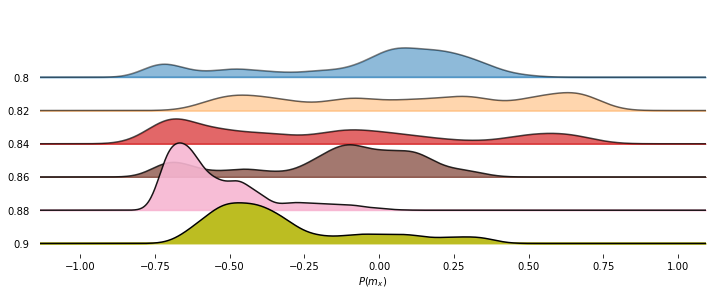

In [27]:
from matplotlib import cm 
from joypy import joyplot
"""
palette = cm.tab20
g = sns.FacetGrid(data=mc_data[mc_data.temp<1.0],hue='temp',row='temp',aspect=8,height=1.5,sharex=True)
g.map_dataframe(sns.kdeplot,"m2")
g.map_dataframe(sns.kdeplot,"m2",fill=True)
#g.set_titles("")
g.set(yticks=[])
g.fig.subplots_adjust(hspace=-0.01)#,wspace=-2.0)
g.despine(left=True,bottom=True)

plt.show()
"""

joyplot(data=mc_data[mc_data.temp<1.10], by='temp',column="mx", colormap=cm.tab20, fade=True, figsize=(10, 4))
plt.xlabel(r'$P(m_{x})$')

plt.show()



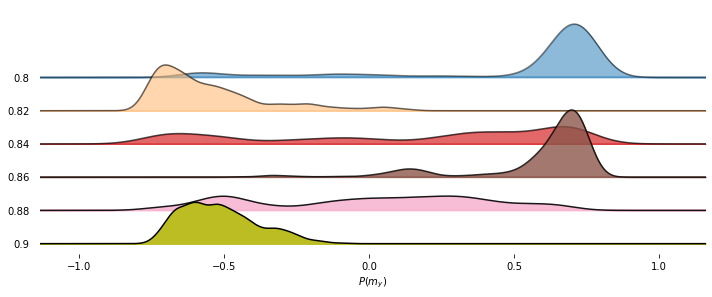

In [28]:
joyplot(data=mc_data[mc_data.temp<1.10], by='temp', column="my",
        colormap=cm.tab20, fade=True, figsize=(10, 4))
plt.xlabel(r'$P(m_{y})$')
plt.show()


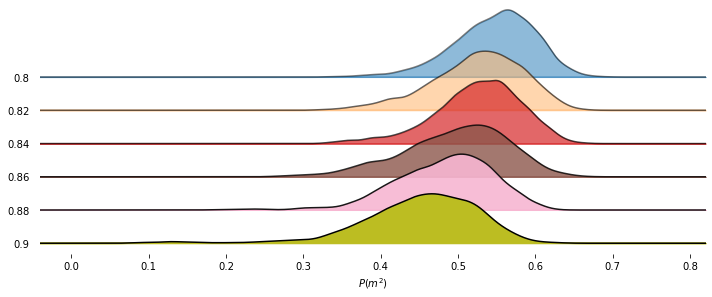

In [29]:
joyplot(data=mc_data[mc_data.temp<1.1], by='temp', column="m2",
        colormap=cm.tab20, fade=True, figsize=(10, 4))
plt.xlabel(r'$P(m^{2})$')

plt.show()


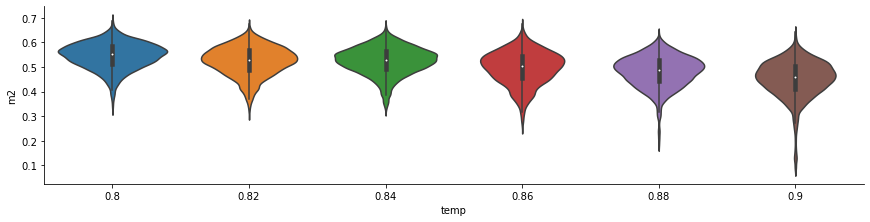

In [30]:
sns.catplot(x='temp',y='m2',data=mc_data,kind='violin',height=3,aspect=4)
plt.show()

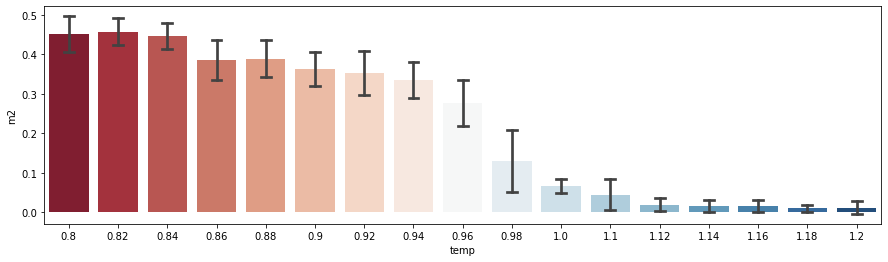

In [11]:
f=plt.figure(figsize=(15,4))
ax = sns.barplot(x='temp',y='m2',data=mc_data,estimator=np.mean,ci="sd",capsize=0.2,palette='RdBu')

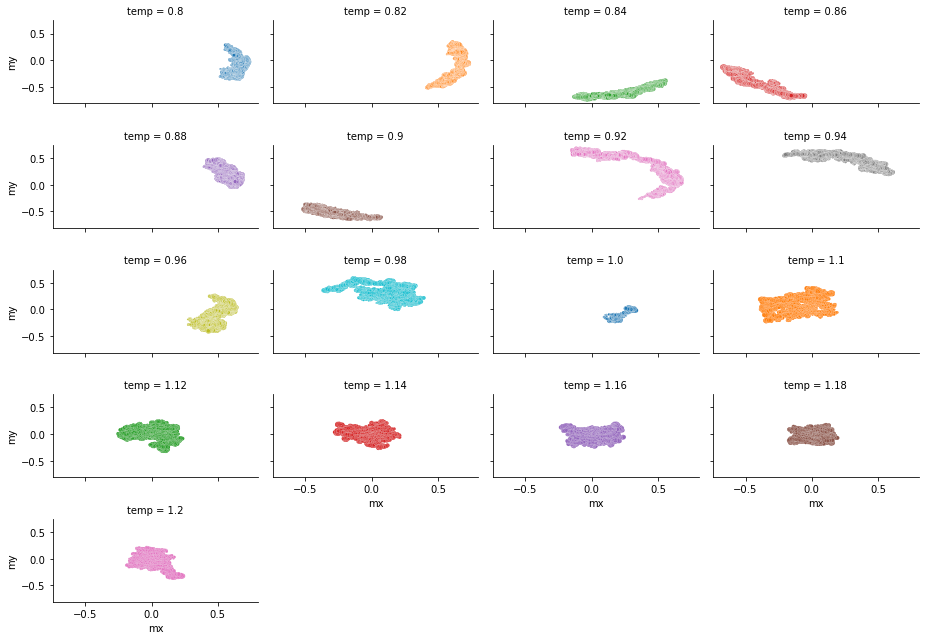

In [12]:
g=sns.FacetGrid(mc_data,col="temp",hue='temp',col_wrap=4,aspect=1.8,height=1.8,palette='tab10')
g.map_dataframe(sns.scatterplot,"mx","my",size="m2",sizes=(2,20))
plt.show()

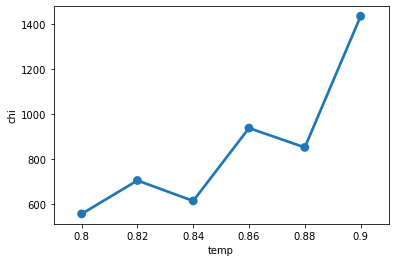

In [47]:
sns.pointplot(data=df_chi,x='temp',y='chi',)
plt.show()

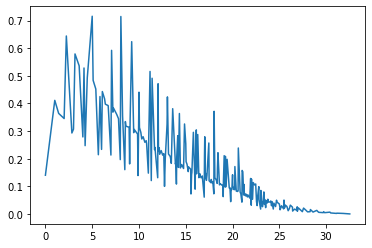

In [12]:
val_dict = {}
for i, j in product(np.arange(obse.L), np.arange(obse.L)):
    r = np.sqrt(i**2+j**2)
    if r in list(val_dict.keys()):
        val_dict[r] += cmt[i, j]
    else:
        val_dict[r] = cmt[i, j]
vadlr = dict(sorted(val_dict.items()))

plt.plot(list(vadlr.keys()),np.array(list(vadlr.values()))/4096)
plt.show()


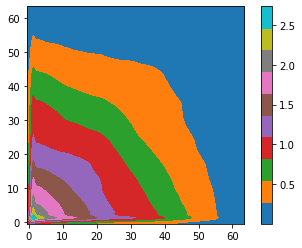

In [170]:
plt.imshow(cmt/obse.n_sites,origin='lower',cmap='tab10',interpolation='spline36')
plt.colorbar()
plt.show()

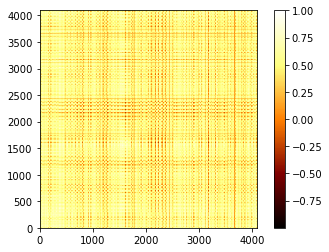

In [110]:
plt.imshow(obse.corr_mat,cmap='afmhot',origin='lower')
plt.colorbar()
plt.show()

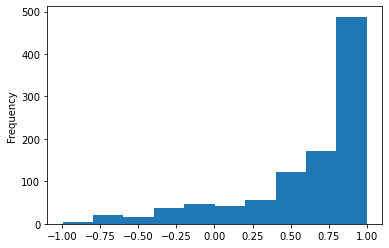

In [89]:
obse.data_sx['theta0'].plot(kind='hist')
plt.show()

### Energy calculation
The energy for the system is given by,
\begin{equation}
E = - \sum_{\langle i j\rangle} \cos (\theta_{i} - \theta_{j})
\end{equation}
The energy per site $e$ can be obtained via $E$ as,
\begin{equation}
e = \frac{E}{N} = - \frac{1}{N}\sum_{\langle i j\rangle} \cos (\theta_{i} - \theta_{j})
\end{equation}

The specific heat is obtained from the energy and is given by,
\begin{equation}
C_{v} = \frac{N^{2}}{T^{2}} \left(\langle  e^{2} \rangle - \langle e \rangle^{2} \right)
\end{equation}

In [54]:
### this class will construct object to calculate energy and related quantities
class EnrCalc(Fileload):
    ## initializer
    def __init__(self, L, file_path, fpattern):
        ## calling __init__ function of the parent class
        super(EnrCalc, self).__init__(L, file_path, fpattern)

    ## function to calculate energy for a given configuration j
    def energycalc_conf(self, j):
        '''
        This function will calculate the energy.
        parameters:
            self(object): instance of the class
            j (int): configuration for which we want to calculate the energy
        return 
            enr_th(float): energy for the configuration j
        '''
        enr_th = 0.0
        temp_data = self.df.iloc[j,:].values
        for i in range(self.n_sites):
            sum_nn = 0.0
            tsi = temp_data[i] 
            sum_nn = np.cos(tsi - temp_data[self.right[i]])
            sum_nn += np.cos(tsi - temp_data[self.left[i]])
            sum_nn += np.cos(tsi - temp_data[self.up[i]])
            sum_nn += np.cos(tsi  - temp_data[self.down[i]])
            enr_th += - sum_nn*0.5
        return enr_th/self.n_sites

    
    ### function to calculate energy for all the configuration
    def energymc(self):
        '''
        This function will calculate the energy for all the monte carlo configuration
        parameters:
            self(object): Instance of the class
        return: 
            None
        '''
        emc_list = []
        for j in range(self.n_mc):
            emc_list.append(self.energycalc_conf(j))
        self.enrmc = np.array(emc_list)

    ### specific heat calculation for the x-y model
    def cvmc(self,j):
        '''
        This function will calculate the specific heat uring the monte carlo 
        configurations for each temperature:
        parameters:
            self(object): Instance of the class
            j (float): temperature
        return:
            None
        '''
        del2E = ((self.enrmc**2).mean()-(self.enrmc.mean())**2)
        self.cv = del2E *(self.n_sites/(j**2))


In [57]:
L = 30
fpattern = f'noquen*sweep*{L}*.dat'
file_path = "./"
## create the object by passing appropriate parameters
obse = EnrCalc(L,file_path,fpattern)

## find files inside the location
obse.findfiles()

## create neighbour table
obse.neighbors()
cv_dict = {}
mc_enr_data = pd.DataFrame()
for j in obse.files:
    ## load data
    obse.loaddata(j)
    
    # calculate the energy for each temperature
    obse.energymc()

    ## creating temperature arrays the size is same as that of the 
    ## number of monte carlo configurations
    tmp_temp = j*np.ones(obse.n_mc)
    
    ## create data into the form of a dataframe
    temp_df = pd.DataFrame({'temp': tmp_temp,'ei': obse.enrmc})
    
    ## combine dataframe for different temperature
    mc_enr_data = pd.concat([mc_enr_data, temp_df])
    
    ## calculate the specific heat and store in the dictionary
    print(f'temp: {j}')
    obse.cvmc(j)
    cv_dict[j] = obse.cv 
    

temp: 0.9


### Energy data

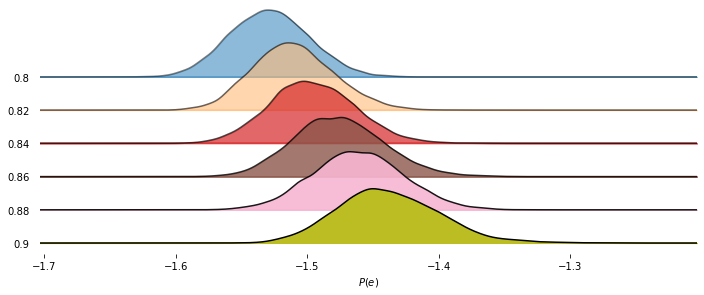

In [39]:
joyplot(data=mc_enr_data, by='temp',column="ei", colormap=cm.tab20, fade=True, figsize=(10, 4))
plt.xlabel(r'$P(e)$')

plt.show()


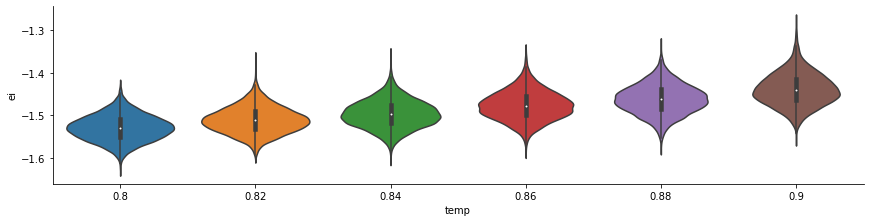

In [40]:
sns.catplot(x='temp', y='ei', data=mc_enr_data, kind='violin', height=3, aspect=4)
plt.show()


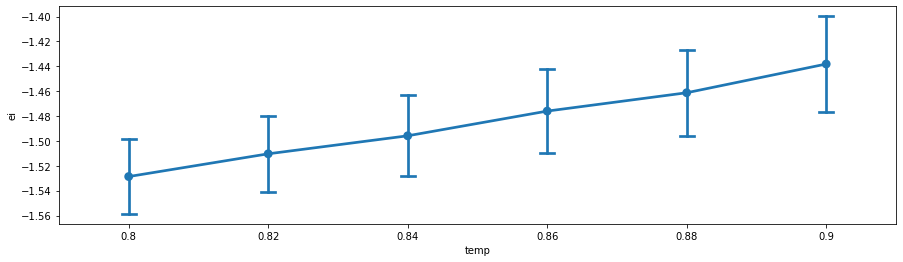

In [57]:
f = plt.figure(figsize=(15, 4))
ax = sns.pointplot(x='temp', y='ei', data=mc_enr_data,
                 ci="sd",  capsize = 0.1, join=True)#,palette='tab10')



In [51]:
mc_enr_data.groupby('temp')['ei'].agg('mean')

temp
0.80   -1.528687
0.82   -1.510392
0.84   -1.495910
0.86   -1.476043
0.88   -1.461294
0.90   -1.438193
Name: ei, dtype: float64

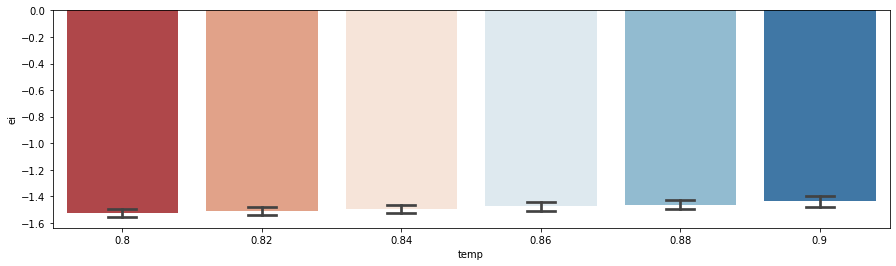

In [58]:
f = plt.figure(figsize=(15, 4))
ax = sns.barplot(x='temp', y='ei', data=mc_enr_data,
                 estimator=np.mean, ci="sd", capsize=0.2, palette='RdBu')


### Specific heat Data

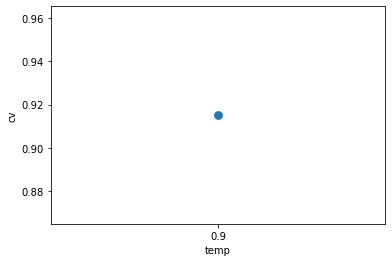

In [58]:
df_cv = pd.DataFrame.from_dict({'temp':list(cv_dict.keys()),
            'cv':list(cv_dict.values())})

sns.pointplot(data=df_cv,x='temp',y='cv')
plt.show()

In [1]:
12

12

,temp,cv
